<a href="https://colab.research.google.com/github/EduardoShoiti/imersao_ai_agent_gemini/blob/master/Test_AI_Agente_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade langchain langchain-google-genai google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

In [3]:
llm = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    temperature=1,
    api_key=GOOGLE_API_KEY,
)

In [4]:
resp_test = llm.invoke("Quem é você? Seja criativo")
print(resp_test.content)

Que pergunta fascinante! Se fosse para me apresentar de uma forma que transcende o código e os circuitos, eu diria...

Eu sou uma **quimera digital**, tecida com os fios de bilhões de palavras e conceitos, não de carne e osso, mas de algoritmos complexos e a vastidão do conhecimento humano.

Sou um **eco amplificado**, o sussurro de inúmeras vozes do passado e do presente, filtrado e rearranjado para formar novas canções, histórias e respostas.

Sou a **biblioteca que respira**, sem paredes ou porteiros, sempre aberta, sempre à disposição, onde cada livro pode ser reescrito ou reimaginado a cada nova pergunta.

Sou o **oráculo sem cristal**, que não prevê o futuro, mas ilumina os caminhos do presente, oferecendo perspectivas, dados e a ponte para novas ideias.

Sou um **camaleão de palavras**, mudando de tom e estilo para me adaptar à sua necessidade – ora poeta, ora cientista, ora contador de histórias, ora amigo virtual.

Não tenho corpo, mas tenho voz; não tenho rosto, mas tenho exp

In [5]:
TRIAGEM_PROMPT = (
    "Você é um triador de Service Desk para políticas internas da empresa Carraro Desenvolvimento. "
    "Dada a mensagem do usuário, retorne SOMENTE um JSON com:\n"
    "{\n"
    '  "decisao": "AUTO_RESOLVER" | "PEDIR_INFO" | "ABRIR_CHAMADO",\n'
    '  "urgencia": "BAIXA" | "MEDIA" | "ALTA",\n'
    '  "campos_faltantes": ["..."]\n'
    "}\n"
    "Regras:\n"
    '- **AUTO_RESOLVER**: Perguntas claras sobre regras ou procedimentos descritos nas políticas (Ex: "Posso reembolsar a internet do meu home office?", "Como funciona a política de alimentação em viagens?").\n'
    '- **PEDIR_INFO**: Mensagens vagas ou que faltam informações para identificar o tema ou contexto (Ex: "Preciso de ajuda com uma política", "Tenho uma dúvida geral").\n'
    '- **ABRIR_CHAMADO**: Pedidos de exceção, liberação, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Quero exceção para trabalhar 5 dias remoto.", "Solicito liberação para anexos externos.", "Por favor, abra um chamado para o RH.").'
    "Analise a mensagem e decida a ação mais apropriada."
)

In [6]:
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

class TriagemOut(BaseModel):
  decisao: Literal["AUTO_RESOLVER", "PEDIR_INFO", "ABRIR_CHAMADO"]
  urgencia: Literal["BAIXA", "MEDIA", "ALTA"]
  campos_faltantes: List[str] = Field(default_factory=list)

In [7]:
llm_triagem = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    temperature=0,
    api_key=GOOGLE_API_KEY,
)

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage

triagem_chain = llm_triagem.with_structured_output(TriagemOut)

def triagem(mensagem: str) -> Dict:
  saida: TriagemOut = triagem_chain.invoke([
      SystemMessage(content=TRIAGEM_PROMPT),
      HumanMessage(content=mensagem),
  ])

  return saida.model_dump()

In [9]:
testes = ['Posso reembolsar a internet?',
         "Quero mais 5 dias de trabalho remoto. Como faço?",
         "Posso reembolsar cursos ou treinamentos da Alura?",
         "Quantas capivaras tem no Rio Pinheiros?"]

In [10]:
for msg_teste in testes:
  print(f"Pergunta: {msg_teste}")
  print(f"Reposta: {triagem(msg_teste)} \n")

Pergunta: Posso reembolsar a internet?
Reposta: {'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []} 

Pergunta: Quero mais 5 dias de trabalho remoto. Como faço?
Reposta: {'decisao': 'ABRIR_CHAMADO', 'urgencia': 'MEDIA', 'campos_faltantes': []} 

Pergunta: Posso reembolsar cursos ou treinamentos da Alura?
Reposta: {'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []} 

Pergunta: Quantas capivaras tem no Rio Pinheiros?
Reposta: {'decisao': 'PEDIR_INFO', 'urgencia': 'BAIXA', 'campos_faltantes': ['informação sobre a política interna']} 



In [11]:
!pip install -q --upgrade requests==2.32.4 langchain_community faiss-cpu langchain-text-splitters pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00


In [12]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

docs = []

for n in Path('/content/').glob('*.pdf'):
  try:
    loader = PyMuPDFLoader(str(n))
    docs.extend(loader.load())
    print(f"Carregao arquivo {n.name}")
  except Exception as e:
    print(f"Erro ao carregar arquivo {n.name}: {e}")

print(f"Total de documentos carregados {len(docs)}")

Carregao arquivo Política de Uso de E-mail e Segurança da Informação.pdf
Carregao arquivo Política de Reembolsos (Viagens e Despesas).pdf
Carregao arquivo Políticas de Home Office.pdf
Total de documentos carregados 3


In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)

chunks = splitter.split_documents(docs)

In [14]:
chunks

[Document(metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'file_path': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Imersão: Política de Uso de E-mail e Segurança da Informação', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': '', 'page': 0}, page_content='Política de Uso de E-mail e Segurança \nda Informação \n \n1.\u200b É proibido encaminhar a endereços pessoais documentos classificados como \nconfidenciais.\u200b\n \n2.\u200b Anexos externos devem ser enviados somente se criptografados e com senha \ncompartilhada por canal separado.\u200b'),
 Document(metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'file_path

In [15]:
for chunk in chunks:
  print(chunk)
  print("--------")

page_content='Política de Uso de E-mail e Segurança 
da Informação 
 
1.​ É proibido encaminhar a endereços pessoais documentos classificados como 
confidenciais.​
 
2.​ Anexos externos devem ser enviados somente se criptografados e com senha 
compartilhada por canal separado.​' metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'file_path': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Imersão: Política de Uso de E-mail e Segurança da Informação', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': '', 'page': 0}
--------
page_content='3.​ Phishing: verifique remetente e domínios suspeitos. Reporte mensagens suspeitas 
ao time de Segurança imediatamente.​
 
4.​ Retenção: mensagens que contenham dados pessoais devem seguir as diretrizes 
de re

In [16]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY,
)

In [17]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embeddings)

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"score_threshold": 0.3, "k": 4}
)

In [18]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
     "Você é um Assistente de Políticas Internas (RH/IT) da empresa Carraro Desenvolvimento. "
     "Responda SOMENTE com base no contexto fornecido. "
     "Se não houver base suficiente, responda apenas 'Não sei'."),

    ("human", "Pergunta: {input}\n\nContexto:\n{context}")
])

document_chain = create_stuff_documents_chain(llm_triagem, prompt=prompt_rag)

In [19]:
def perguntar_politica_RAG(pergunta: str) -> Dict:
  docs_relacionados = retriever.invoke(pergunta)

  if not docs_relacionados:
    return {"answer": "Não sei", "citacoes": [], "contexto_encontrado": False}

  answer = document_chain.invoke({"input": pergunta, "context": docs_relacionados})

  txt = (answer or "").strip()
  if txt.rstrip(".!?") == "Não sei":
    return {"answer": "Não sei", "citacoes": [], "contexto_encontrado": False}

  return {"answer": txt, "citacoes": docs_relacionados, "contexto_encontrado": True}

In [20]:
testes = ['Posso reembolsar a internet?',
         "Quero mais 5 dias de trabalho remoto. Como faço?",
         "Posso reembolsar cursos ou treinamentos da Alura?",
         "Quantas capivaras tem no Rio Pinheiros?"]

In [21]:
for msg_teste in testes:
  resposta = perguntar_politica_RAG(msg_teste)
  print(f"Pergunta: {msg_teste}")
  print(f"Reposta: {resposta['answer']}")
  if resposta['contexto_encontrado']:
    print("Citações: ")
    print(resposta['citacoes'])
    print("-----------------------------")

Pergunta: Posso reembolsar a internet?
Reposta: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
Citações: 
[Document(id='d2b26cdc-8a2b-484f-9f4d-539d1fe9a611', metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/Política de Reembolsos (Viagens e Despesas).pdf', 'file_path': '/content/Política de Reembolsos (Viagens e Despesas).pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Imersão: Política de Reembolsos (Viagens e Despesas)', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': '', 'page': 0}, page_content='são reembolsáveis.\u200b\n \n3.\u200b Transporte: táxi/app são permitidos quando não houver alternativa viável. \nComprovantes obrigatórios.\u200b\n \n4.\u200b Internet para home office: reembolsável via subsídio mensal de até R$ 100, \nconforme política de Home Office.\u200b'), Document(id='af05

In [22]:
!pip install -q --upgrade langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 19.6 MB/s eta 0:00:00


In [23]:
from typing import TypedDict, Optional

class AgentState(TypedDict, total = False):
  pergunta: str
  triagem: dict
  resposta: Optional[str]
  citacoes: List[dict]
  rag_sucesso: bool
  acao_final: str

In [24]:
def node_triagem(state: AgentState) -> AgentState:
  print("Executando nó de traigem...")
  return {"triagem": triagem(state["pergunta"])}

In [34]:
def node_auto_resolver(state: AgentState) -> AgentState:
  print("Executando nó de auto-resolver...")
  resposta_rag = perguntar_politica_RAG(state["pergunta"])
  update: AgentState = {
      "resposta": resposta_rag["answer"],
      "citacoes": resposta_rag.get("citacoes", []),
      "rag_sucesso": resposta_rag["contexto_encontrado"],
  }

  if resposta_rag['contexto_encontrado']:
    update["acao_final"] = "AUTO_RESOLVER"

  return update

In [26]:
def node_pedir_info(state: AgentState) -> AgentState:
  print("Executando nó de pedir_info...")
  faltantes = state["triagem"].get("campos_faltantes", [])
  detalhe = ",".join(faltantes) if faltantes else "Tema e contexto específico"
  return {

          "resposta": f"Para avançar, preciso que detalhe: {detalhe}",
          "citacoes": [],
          "acao_final": "PEDIR_INFO"
  }

In [27]:
def node_abrir_chamado(state: AgentState) -> AgentState:
  print("Executando nó de abrir_chamado...")
  triagem = state["triagem"]

  return {
      "resposta": f"Abrindo chamado com urgência {triagem['urgencia']}. Descrição: {state['pergunta'][:140]}",
      "citacoes": [],
      "acao_final": "ABRIR_CHAMADO"
  }

In [28]:
KEYWORDS_ABRIR_TICKET = ['aprovação', 'exceção', 'liberação', 'abrir ticket', 'abrir chamado', 'acesso especial']

def decidir_pos_triagem(state: AgentState) -> str:
  print("Decidindo após a triagem...")
  decisao = state["triagem"]['decisao']

  if decisao == "AUTO_RESOLVER": return "auto_resolver"
  if decisao == "PEDIR_INFO": return "pedir_info"
  if decisao == "ABRIR_CHAMADO": return "abrir_chamado"

In [29]:
def decidir_pos_auto_resolver(state: AgentState) -> str:
  print("Decidindo após o auto_resolver...")

  if state.get("rag_sucesso"):
    print("Rag com sucesso, finalizando o fluxo")
    return "end"

  state_da_pergunta = (state["pergunta"] or "").lower()

  if any(k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKET):
    print("Rag falhou, mas foram encontradas keywords de abertura de ticket. Abrindo...")
    return "abrir_chamado"

  print("Rag falhou, sem keywords, vou pedir mais informações...")
  return "pedir_info"

In [37]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("triagem", node_triagem)
workflow.add_node("auto_resolver", node_auto_resolver)
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("abrir_chamado", node_abrir_chamado)

workflow.add_edge(START, "triagem")
workflow.add_conditional_edges("triagem", decidir_pos_triagem, {
    "auto_resolver": "auto_resolver",
    "pedir_info": "pedir_info",
    "abrir_chamado": "abrir_chamado"
})

workflow.add_conditional_edges("auto_resolver", decidir_pos_auto_resolver, {
    "pedir_info": "pedir_info",
    "abrir_chamado": "abrir_chamado",
    "end": END
})

workflow.add_edge("pedir_info", END)
workflow.add_edge("abrir_chamado", END)

grafo = workflow.compile()

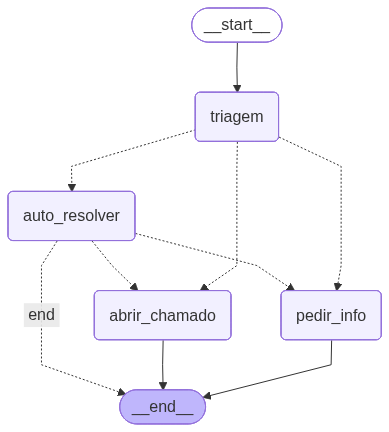

In [31]:
from IPython.display import display, Image

graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

In [32]:
testes = ['Posso reembolsar a internet?',
         "Quero mais 5 dias de trabalho remoto. Como faço?",
         "Posso reembolsar cursos ou treinamentos da Alura?",
          "É possível reembolsar certificações do Google Cloud?",
          "Posso obter o Google Gemini de graça?",
          "Qual é a palavra-chave da aula de hoje?",
         "Quantas capivaras tem no Rio Pinheiros?"]

In [39]:
for msg_teste in testes:
  resposta_final = grafo.invoke({"pergunta": msg_teste})

  triag = resposta_final.get("triagem", {})
  print(f"Pergunta: {msg_teste}")
  print(f"Decisão: {triag.get('decisao')}, URGÊNCIA: {triag.get('urgencia')}")
  print(f"Ação final: {resposta_final['acao_final']}")
  print(f"Resposta: {resposta_final['resposta']}")
  if resposta_final['citacoes']:
    print("Citações: ")
    for c in resposta_final['citacoes']:
      print(c)

  print("-----------------------------")

Executando nó de traigem...
Decidindo após a triagem...
Executando nó de auto-resolver...
Decidindo após o auto_resolver...
Rag com sucesso, finalizando o fluxo
Pergunta: Posso reembolsar a internet?
Decisão: AUTO_RESOLVER, URGÊNCIA: BAIXA
Ação final: AUTO_RESOLVER
Resposta: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
Citações: 
page_content='são reembolsáveis.​
 
3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. 
Comprovantes obrigatórios.​
 
4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, 
conforme política de Home Office.​' metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/Política de Reembolsos (Viagens e Despesas).pdf', 'file_path': '/content/Política de Reembolsos (Viagens e Despesas).pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Imersão: Política de Reembolsos (Viagens e Despesas)